## 2D Model

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP,SaasPyroModel
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

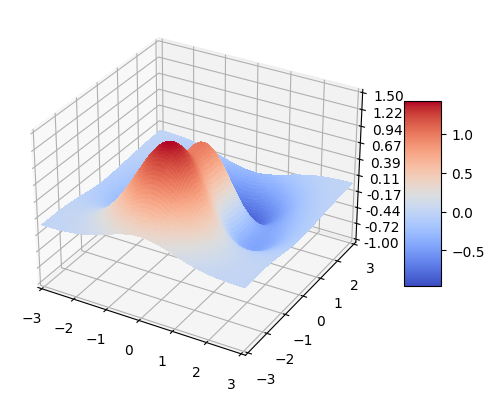

In [30]:
def F(X1,X2):
    return (1-(X1**2+X2**3))*np.exp(-(X1**2+X2**2)/2)

x1 = np.linspace(-3,3,101)
x2 = np.linspace(-3,3,101)
x1,x2 = np.meshgrid(x1,x2)
y = F(x1,x2)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)
surf = ax.plot_surface(x1,x2,y, rstride=1, cstride=1,
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Retrive initial dataset

In [31]:
n = 10 # Number of training points
train_x1 = torch.rand(n,1)*3
train_x2 = torch.rand(n,1)*3
train_y = F(train_x1,train_x2)
best_observed = train_y.max().item()
train_x1,train_x2,train_y,best_observed

(tensor([[2.5275],
         [1.3974],
         [0.6545],
         [2.8549],
         [2.6354],
         [0.1678],
         [1.0355],
         [2.8781],
         [2.3691],
         [2.8255]]),
 tensor([[2.8388],
         [1.2751],
         [0.0134],
         [2.4364],
         [0.6283],
         [0.0031],
         [2.4020],
         [1.6301],
         [2.6282],
         [2.6210]]),
 tensor([[-0.0206],
         [-0.5056],
         [ 0.4614],
         [-0.0189],
         [-0.1578],
         [ 0.9583],
         [-0.4553],
         [-0.0489],
         [-0.0435],
         [-0.0149]]),
 0.958275556564331)

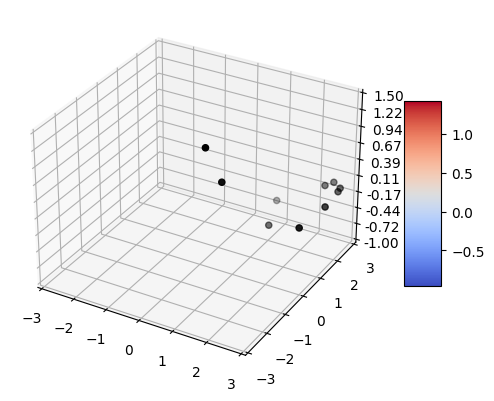

In [32]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

# surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
#                       cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(train_x1,train_x2,train_y,color='black')

plt.show()

## Fit GP model
Default:
    likelihood: standard Gaussian likelihood with inferred noise level
    Covar_module: Matern kernel
    Mean_module: Constant mean

In [33]:
train_x = torch.stack((train_x1,train_x2),-1).squeeze(1)
train_x

tensor([[2.5275, 2.8388],
        [1.3974, 1.2751],
        [0.6545, 0.0134],
        [2.8549, 2.4364],
        [2.6354, 0.6283],
        [0.1678, 0.0031],
        [1.0355, 2.4020],
        [2.8781, 1.6301],
        [2.3691, 2.6282],
        [2.8255, 2.6210]])

In [35]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

model.eval()

# Initialize plot
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)
# test model on 101 regular spaced points on the interval [0, 10]
test_x1 = torch.linspace(0, 10, 101)
test_x2 = torch.linspace(0, 10, 101)
test_x = torch.stack((test_x1,test_x2),-1).squeeze(1)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')


# ax.legend(['Observed Data', 'Mean', 'Confidence'])
# plt.tight_layout()
plt.show()

ValueError: input operand has more dimensions than allowed by the axis remapping

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1259f8670> (for post_execute):


AttributeError: 'Line3D' object has no attribute '_verts3d'

AttributeError: 'Line3D' object has no attribute '_verts3d'

<Figure size 640x480 with 1 Axes>

## Fully Bayesian GP Models (High dimensional problems)
Sample a set of hyperparameters from the posterior
Prior: sparse axis-aligned subspace priors (SAAS) model to identify the most important parameters

In [358]:
# saas_gp = SaasFullyBayesianSingleTaskGP(train_x, train_y)
# fit_fully_bayesian_model_nuts(saas_gp)
# posterior = saas_gp.posterior(test_x)

## Acquistion function
Morte-Carlo sampling:
1. Sampling joint posterior over q points
2. evaluate the current best for each sample
3. maximise over q
4. average over the samples

# EI Defaults:
1. Sampler: SobolQMCNormalSampler
2. Objective: IdentityMCObjective() (objective under which samples is evaluated)

In [365]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Noisy Expected Improvement:
Does not assume best_f, compute improvement over the previous points and average

In [372]:
NEI = qNoisyExpectedImprovement(
    model = model,
    X_baseline = train_x,
    prune_baseline= True,
)

## qUCB
beta: control the tradeoff between mean and variance.

In [374]:
UCB = qUpperConfidenceBound(
    model = model,
    beta = 0.6,
)

## Optimise acquisition function

In [375]:
candidates_x,_ = optimize_acqf(
    acq_function = UCB,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[ 3.3837],
         [ 8.1287],
         [ 1.5170],
         [ 2.7875],
         [ 2.0750],
         [10.0000],
         [ 9.5493],
         [ 7.5612],
         [ 1.0320],
         [ 5.2957]]),
 tensor([[ 0.4081],
         [ 0.9625],
         [ 0.9992],
         [ 0.4990],
         [ 0.8862],
         [-0.5440],
         [-0.1242],
         [ 0.9575],
         [ 0.8584],
         [-0.2781]]))

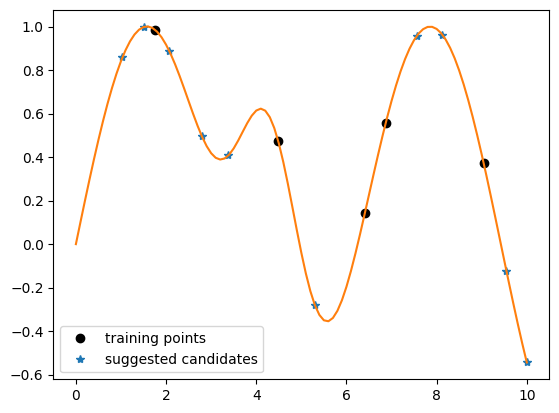

In [376]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

## Take in suggested data, forming new training dataset

In [377]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y

(tensor([[ 6.4067],
         [ 6.8719],
         [ 1.7555],
         [ 9.0433],
         [ 4.4848],
         [ 3.3837],
         [ 8.1287],
         [ 1.5170],
         [ 2.7875],
         [ 2.0750],
         [10.0000],
         [ 9.5493],
         [ 7.5612],
         [ 1.0320],
         [ 5.2957]]),
 tensor([[ 0.1410],
         [ 0.5573],
         [ 0.9853],
         [ 0.3723],
         [ 0.4754],
         [ 0.4081],
         [ 0.9625],
         [ 0.9992],
         [ 0.4990],
         [ 0.8862],
         [-0.5440],
         [-0.1242],
         [ 0.9575],
         [ 0.8584],
         [-0.2781]]))

## Posterior model

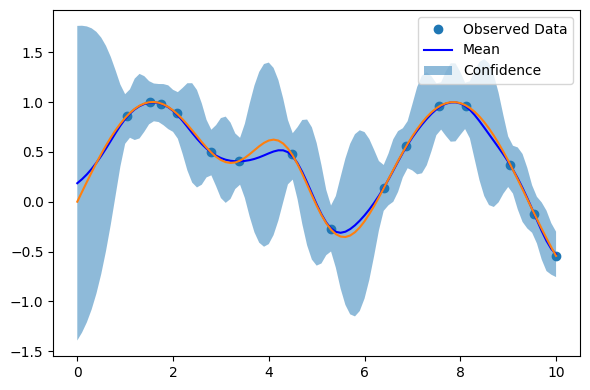

In [378]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Second run

In [379]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [380]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[3.4276],
         [3.9740],
         [7.9156],
         [0.0000],
         [7.3113],
         [4.2973],
         [1.3308],
         [8.4563],
         [7.7840],
         [0.4414]]),
 tensor([[4.1863e-01],
         [6.0921e-01],
         [9.9811e-01],
         [1.3995e-08],
         [8.5651e-01],
         [5.8490e-01],
         [9.7156e-01],
         [8.2404e-01],
         [9.9756e-01],
         [4.2722e-01]]))

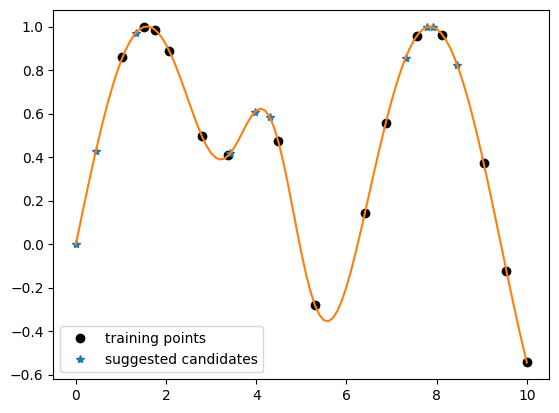

In [381]:
plt.plot(posterior_x,posterior_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

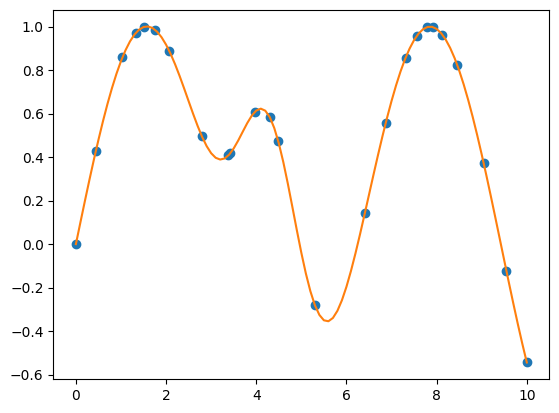

In [382]:
combine_x = (posterior_x,candidates_x)
combine_y = (posterior_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')
plt.plot(x,F(x))

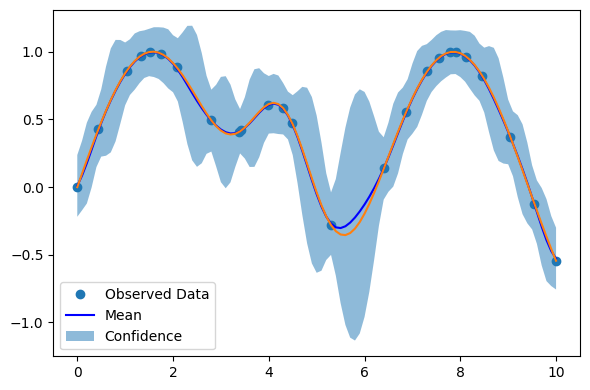

In [383]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()